In [ ]:
# CNN


In [2]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers, models, Input
from keras import backend as K
from keras import regularizers
from keras.utils import Sequence
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime, time
import os, sys
import tqdm
import gc
from multiprocessing import Process
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float16'

Using TensorFlow backend.


In [7]:
# INIT
# PART 1
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 10001, 1000))
number_samples = [256, 512, 1024, 2048, 4096, 8192] 
# number_samples = [4096, 8192]

# cnn_type = "classification"  # {"classification", "regression"}
validation_size, noise_floor = 0.33, -90.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y, number_image_channels, su_szie = 1000, 1000, 7, 30
pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
intensity_degradation, slope = 'log', 4  # 'log', 'linear'
max_pus_num, max_sus_num = 20, 1
propagation_model = 'log' # 'splat', 'log', 'testbed'
noise, std = True, 1
if su_shape == 'circle':
    su_param = Circle(su_szie)
elif su_shape == 'square':
    su_param = Square(su_szie)
else:
    su_param = None
    
sensors = False
if sensors:
    sensors_num = 3600
    sensors_file_path = "rsc/sensors/" + str(max(max_x, max_y)) + "/" + str(sensors_num) + "/sensors"
# num_pus = (data_reg.shape[1] - 3)//3

# PART 2
number_of_proccessors = 6
memory_size_allowed = 4 # in Gigabyte
float_size = 0
if float_memory_used == "float16":
    float_size = 16
elif float_memory_used == "float" or "float32":
    float_size = 32
elif float_memory_used == "float8":
    float_size = 8


batch_size = int(memory_size_allowed / (max_x * max_y * number_image_channels * float_size/(8 * 1024 ** 3)))


dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (intensity_degradation + '_' + str(slope))) + (
    "/" + str(sensors_num) + "sensors" if sensors else "/pus") + "/images"

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [8]:
image_dir

'ML/data/pictures_1000_1000/log/noisy_std_1/pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/images'

In [9]:
# LOAD DATA
num_columns = (sensors_num if sensors else max_pus_num * 3 + 1) + max_sus_num * 3 + 2
cols = [i for i in range(num_columns)]
dataset_name = "dynamic_pus_using_pus_50000_min10_max20PUs_1SUs_1000grid_log_noisy_std1_202005_0400_37.txt"
max_dataset_name = "dynamic_pus_max_power_50000_min10_max20PUs_1SUs_1000grid_log_noisy_std1_202005_0400_37.txt"
with open('/'.join(image_dir.split('/')[:-1]) + '/datasets' + dtime + '.txt', 'w') as set_file:
    set_file.write(dataset_name + "\n")
    set_file.write(max_dataset_name)

dataframe = pd.read_csv('ML/data/' + dataset_name, delimiter=',', header=None, names=cols)
dataframe_max = pd.read_csv('ML/data/' + max_dataset_name, delimiter=',', header=None)

dataframe.reset_index(drop=True, inplace=True)
dataframe_max.reset_index(drop=True, inplace=True)

dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-2:]]], axis=1,
                        ignore_index=True)

idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
dataframe_tot.drop(idx, inplace=True)

data_reg = dataframe_tot.values
# data_reg = np.concatenate((dataframe_tot.values[:, 0:dataframe_tot.shape[1]-3], 
#                            dataframe_tot.values[:, dataframe_tot.shape[1]-1:dataframe_tot.shape[1]]), axis=1)
# data_class = dataframe_tot.values[:, 0:dataframe_tot.shape[1]-1]
# y_class_power = dataframe_tot.values[:, -1]

if sensors:
    sensors_location = []
    with open(sensors_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(' ')
            sensors_location.append(Point(int(float(line[0])), int(float(line[1]))))
del dataframe, dataframe_tot, dataframe_max

In [14]:
data_reg[1]

array([ 13.   , 818.   , 645.   ,  -6.144, 332.   , 427.   ,  -9.246,
       393.   , 494.   , -27.675, 539.   , 449.   , -13.51 , 328.   ,
       742.   , -29.475, 503.   , 988.   ,  -3.919, 326.   , 156.   ,
       -15.73 , 207.   , 312.   , -19.223, 666.   , 820.   , -13.907,
       256.   ,  76.   , -20.374, 493.   ,  44.   ,  -5.245, 428.   ,
       853.   , -12.285, 366.   , 361.   , -29.037,   1.   ,   0.   ,
       141.   , -19.892,   1.   ,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,  39.066,  37.808])

In [6]:
data_reg = data_reg[0:35000][:]

In [10]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def get_pu_param(pu_shape: str, intensity_degradation: str, pu_p: float, noise_floor: float, slope: float):
    pu_param = None
    if pu_shape == 'circle':
        if intensity_degradation == "linear":
            pu_param = Circle(int((pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Circle(int(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'square':
        if intensity_degradation == "linear":
            pu_param = Square(int(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Square(int(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'point':
        pu_param = None
    else:
        raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
    return pu_param

def create_image(data, slope, sensors_num, style="raw_power_z_score", noise_floor=-90, pu_shape= 'circle', pu_param=None, 
                 su_shape='circle', su_param=None, intensity_degradation="log", max_pu_power: float=0):  
    # style = {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_min_max_norm":
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        
        # creating pu matrix
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        if not sensors:
            pus_num = int(data[0])
#             print(pus_num)
            for pu_i in range(pus_num):
                pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1]))) 
                pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2])))
                pu_p = data[pu_i * 3 + 3]
#                 print(pu_x, pu_y, pu_p)
                if pu_param is None:
                    pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
                else:
                    pu_param_p = pu_param
                points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[0][int(abs(pu_p))//5][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[0][int(abs(pu_p))//5][point.p.x][point.p.y] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[0][int(abs(pu_p))//5][point.p.x][point.p.y] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        else:
            ss_param, ss_shape = pu_param, pu_shape
            for ss_i in range(sensors_num):
                ss_x, ss_y, ss_p = max(0, min(max_x-1, int(sensors_location[ss_i].x))), max(0, min(max_x-1, int(
                    sensors_location[ss_i].y))), max(noise_floor, data[ss_i])
                ss_channel = 0 
                if -50.0 <= ss_p < -40.0:
                    ss_channel = 1
                elif -60.0 <= ss_p < -50.0:
                    ss_channel = 2
                elif -70.0 <= ss_p < -60.0:
                    ss_channel = 3
                elif -80.0 <= ss_p < -70.0:
                    ss_channel = 4
#                 elif -70.0 <= ss_p < -65.0:
#                     ss_channel = 5
                elif ss_p < -80.0:
                    ss_channel = 5
                if ss_param is None:
                    ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p, noise_floor, slope)
                else:
                    ss_param_p = ss_param
                points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, param=ss_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[0][ss_channel][point.p.x][point.p.y] += (ss_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1])))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2])))
            su_p = data[su_num_idx + su_i * 3 + 3]
#             su_p = su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -1
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[0][su_channel][point.p.x][point.p.y] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1])))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2])))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[0][su_channel][point.p.x][point.p.y] += su_intensity
        del points
        return image
        
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        for pu_i in range(pus_num):
            pu_x, pu_y, pu_p = max(0, min(max_x-1, int(data[pu_i*3]))), max(0, min(max_x-1, int(data[pu_i*3+1]))), data[pu_i*3+2]
            if pu_param is None:
                pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
            else:
                pu_param_p = pu_param
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += max((pu_p - slope * point.dist + abs(noise_floor))
                                                              /(pu_p + abs(noise_floor)), 0)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            image[0][0][point.p.x][point.p.y] = 1
                        else:
                            image[0][0][point.p.x][point.p.y] += max((pu_p - slope * 10*math.log10(point.dist) + abs(noise_floor))
                                                                 /(pu_p + abs(noise_floor)), 0)
                    image[0][0][point.p.x][point.p.y] = min(image[0][0][point.p.x][point.p.y], 1.0)
                        
        # creating SU image
        su_num = (len(data) - pus_num * 3) // 2
        if not (len(data) - pus_num * 3) % 2:
            raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
#         su_image = np.zeros((max_x, max_y), dtype=float_memory_used)
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        su_intensity = 1.
        for su_i in range(su_num):
            su_x, su_y, su_p = max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) +su_i*2]))
                                  ), max(0, min(max_x-1, int(data[pus_num * (3 if not sensors else 1) + su_i*2+1]))), su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if number_image_channels > 1:
                        image[0][1][point.p.x][point.p.y] = su_intensity
                    elif number_image_channels == 1:
                        image[0][0][point.p.x][point.p.y] = su_intensity
#         return np.array([pu_image, su_image, [[0.] * max_y for _ in range(max_x)]], dtype='float32') # return like this to be able to display as an RGB image with pyplot.imshow(imsave)
#         return np.append(pu_image, su_image, axis=0)
        return image
        
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set((Point(x, y) for x in range(max(-r, -max_x), min(r, max_x) + 1) 
                             for y in range(max(-r, -max_y), min(r, max_y) + 1)))
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        del square_points
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    elif shape == 'point':
        return [PointWithDistance(center, 0)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
        
def read_image(image_num):
    if style == "image_intensity":
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        image = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
    elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
        suffix = 'npz'  # npy, npz
        image = np.load(image_dir + '/image' + str(image_num) + '.' + suffix)  
        if type(image) == np.lib.npyio.NpzFile:
            image = image['a']
    
    return image
    
# TODO: Consider using min_max normalization becasue difference between values using
# z-score is huge since most of the pixels have the same value, noise floor

(array([0.]), array([0., 1.]), <a list of 1 Patch objects>)

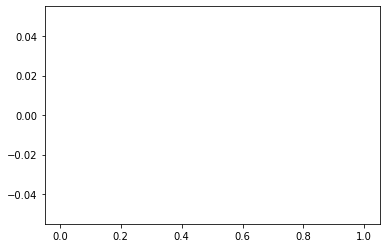

In [14]:
plt.hist(data_reg[:,3:3:33], bins='auto')

In [30]:
# Saving images once to save time
# run this cell just for creating images
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg[image_num], slope=slope, style=style, noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0)
        if style == "image_intensity":
            if number_image_channels != 3:
                image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                               dtype=float_memory_used), axis=0)
            image_save = np.swapaxes(image, 0, 2)
            plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
        elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
    #         np.save(image_dir + '/image' + str(image_num), image)
            np.savez_compressed(image_dir + '/image' + str(image_num), a=image)
        del image
        

In [35]:
jobs = []
proc_sizes = [data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|██████████| 7664/7664 [12:58:23<00:00,  6.09s/it]


In [11]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point)

1 Point(x=25, y=25)
2 Point(x=25, y=75)
3 Point(x=25, y=125)
4 Point(x=25, y=175)
5 Point(x=25, y=225)
6 Point(x=25, y=275)
7 Point(x=25, y=325)
8 Point(x=25, y=375)
9 Point(x=25, y=425)
10 Point(x=25, y=475)
11 Point(x=25, y=525)
12 Point(x=25, y=575)
13 Point(x=25, y=625)
14 Point(x=25, y=675)
15 Point(x=25, y=725)
16 Point(x=25, y=775)
17 Point(x=25, y=825)
18 Point(x=25, y=875)
19 Point(x=25, y=925)
20 Point(x=25, y=975)
21 Point(x=75, y=25)
22 Point(x=75, y=75)
23 Point(x=75, y=125)
24 Point(x=75, y=175)
25 Point(x=75, y=225)
26 Point(x=75, y=275)
27 Point(x=75, y=325)
28 Point(x=75, y=375)
29 Point(x=75, y=425)
30 Point(x=75, y=475)
31 Point(x=75, y=525)
32 Point(x=75, y=575)
33 Point(x=75, y=625)
34 Point(x=75, y=675)
35 Point(x=75, y=725)
36 Point(x=75, y=775)
37 Point(x=75, y=825)
38 Point(x=75, y=875)
39 Point(x=75, y=925)
40 Point(x=75, y=975)
41 Point(x=125, y=25)
42 Point(x=125, y=75)
43 Point(x=125, y=125)
44 Point(x=125, y=175)
45 Point(x=125, y=225)
46 Point(x=125, y=27

In [47]:
for idx, point in enumerate(sensors_location):
    print(idx+1, point,"close") if math.sqrt((point.x-917)**2+(point.y-415)**2)<=1.5 else None

823 Point(x=916, y=416) close


In [47]:
count = [0, 0, 0, 0]
idxx = [[],[],[],[]]
for i in range(data_reg.shape[0]):
    pus_c = int(data_reg[i][0]) * 3 + 1
    idx = int(data_reg[i][pus_c]) - 1
    count[idx] += 1
    idxx[idx].append(i)

In [61]:
print(count)
print(idxx[3])

[24178, 12235, 5997, 3024]
[18, 37, 42, 58, 79, 82, 89, 90, 103, 124, 142, 149, 171, 173, 189, 207, 233, 238, 269, 277, 293, 319, 331, 341, 387, 396, 404, 410, 418, 420, 432, 440, 444, 497, 525, 539, 544, 614, 616, 619, 627, 632, 633, 645, 648, 651, 663, 732, 775, 778, 843, 902, 923, 949, 965, 967, 968, 988, 996, 1018, 1020, 1024, 1030, 1036, 1075, 1084, 1105, 1116, 1129, 1133, 1140, 1142, 1152, 1168, 1171, 1188, 1250, 1251, 1264, 1279, 1288, 1306, 1329, 1367, 1369, 1389, 1390, 1421, 1430, 1435, 1440, 1447, 1450, 1456, 1463, 1534, 1539, 1550, 1562, 1594, 1606, 1621, 1632, 1654, 1658, 1664, 1683, 1714, 1754, 1773, 1796, 1820, 1821, 1843, 1848, 1865, 1871, 1897, 1905, 1938, 1943, 1948, 1997, 2017, 2023, 2040, 2053, 2062, 2087, 2103, 2110, 2116, 2119, 2148, 2157, 2169, 2182, 2220, 2227, 2288, 2326, 2364, 2372, 2387, 2402, 2426, 2431, 2434, 2436, 2441, 2447, 2472, 2478, 2491, 2497, 2532, 2543, 2557, 2582, 2588, 2619, 2628, 2706, 2741, 2742, 2743, 2747, 2751, 2762, 2788, 2807, 2870, 2874, 2

In [32]:
imm = read_image(0)

In [18]:
print(data_reg[1][-7:])

[-78.997   1.    581.    975.     39.628   0.     31.139]


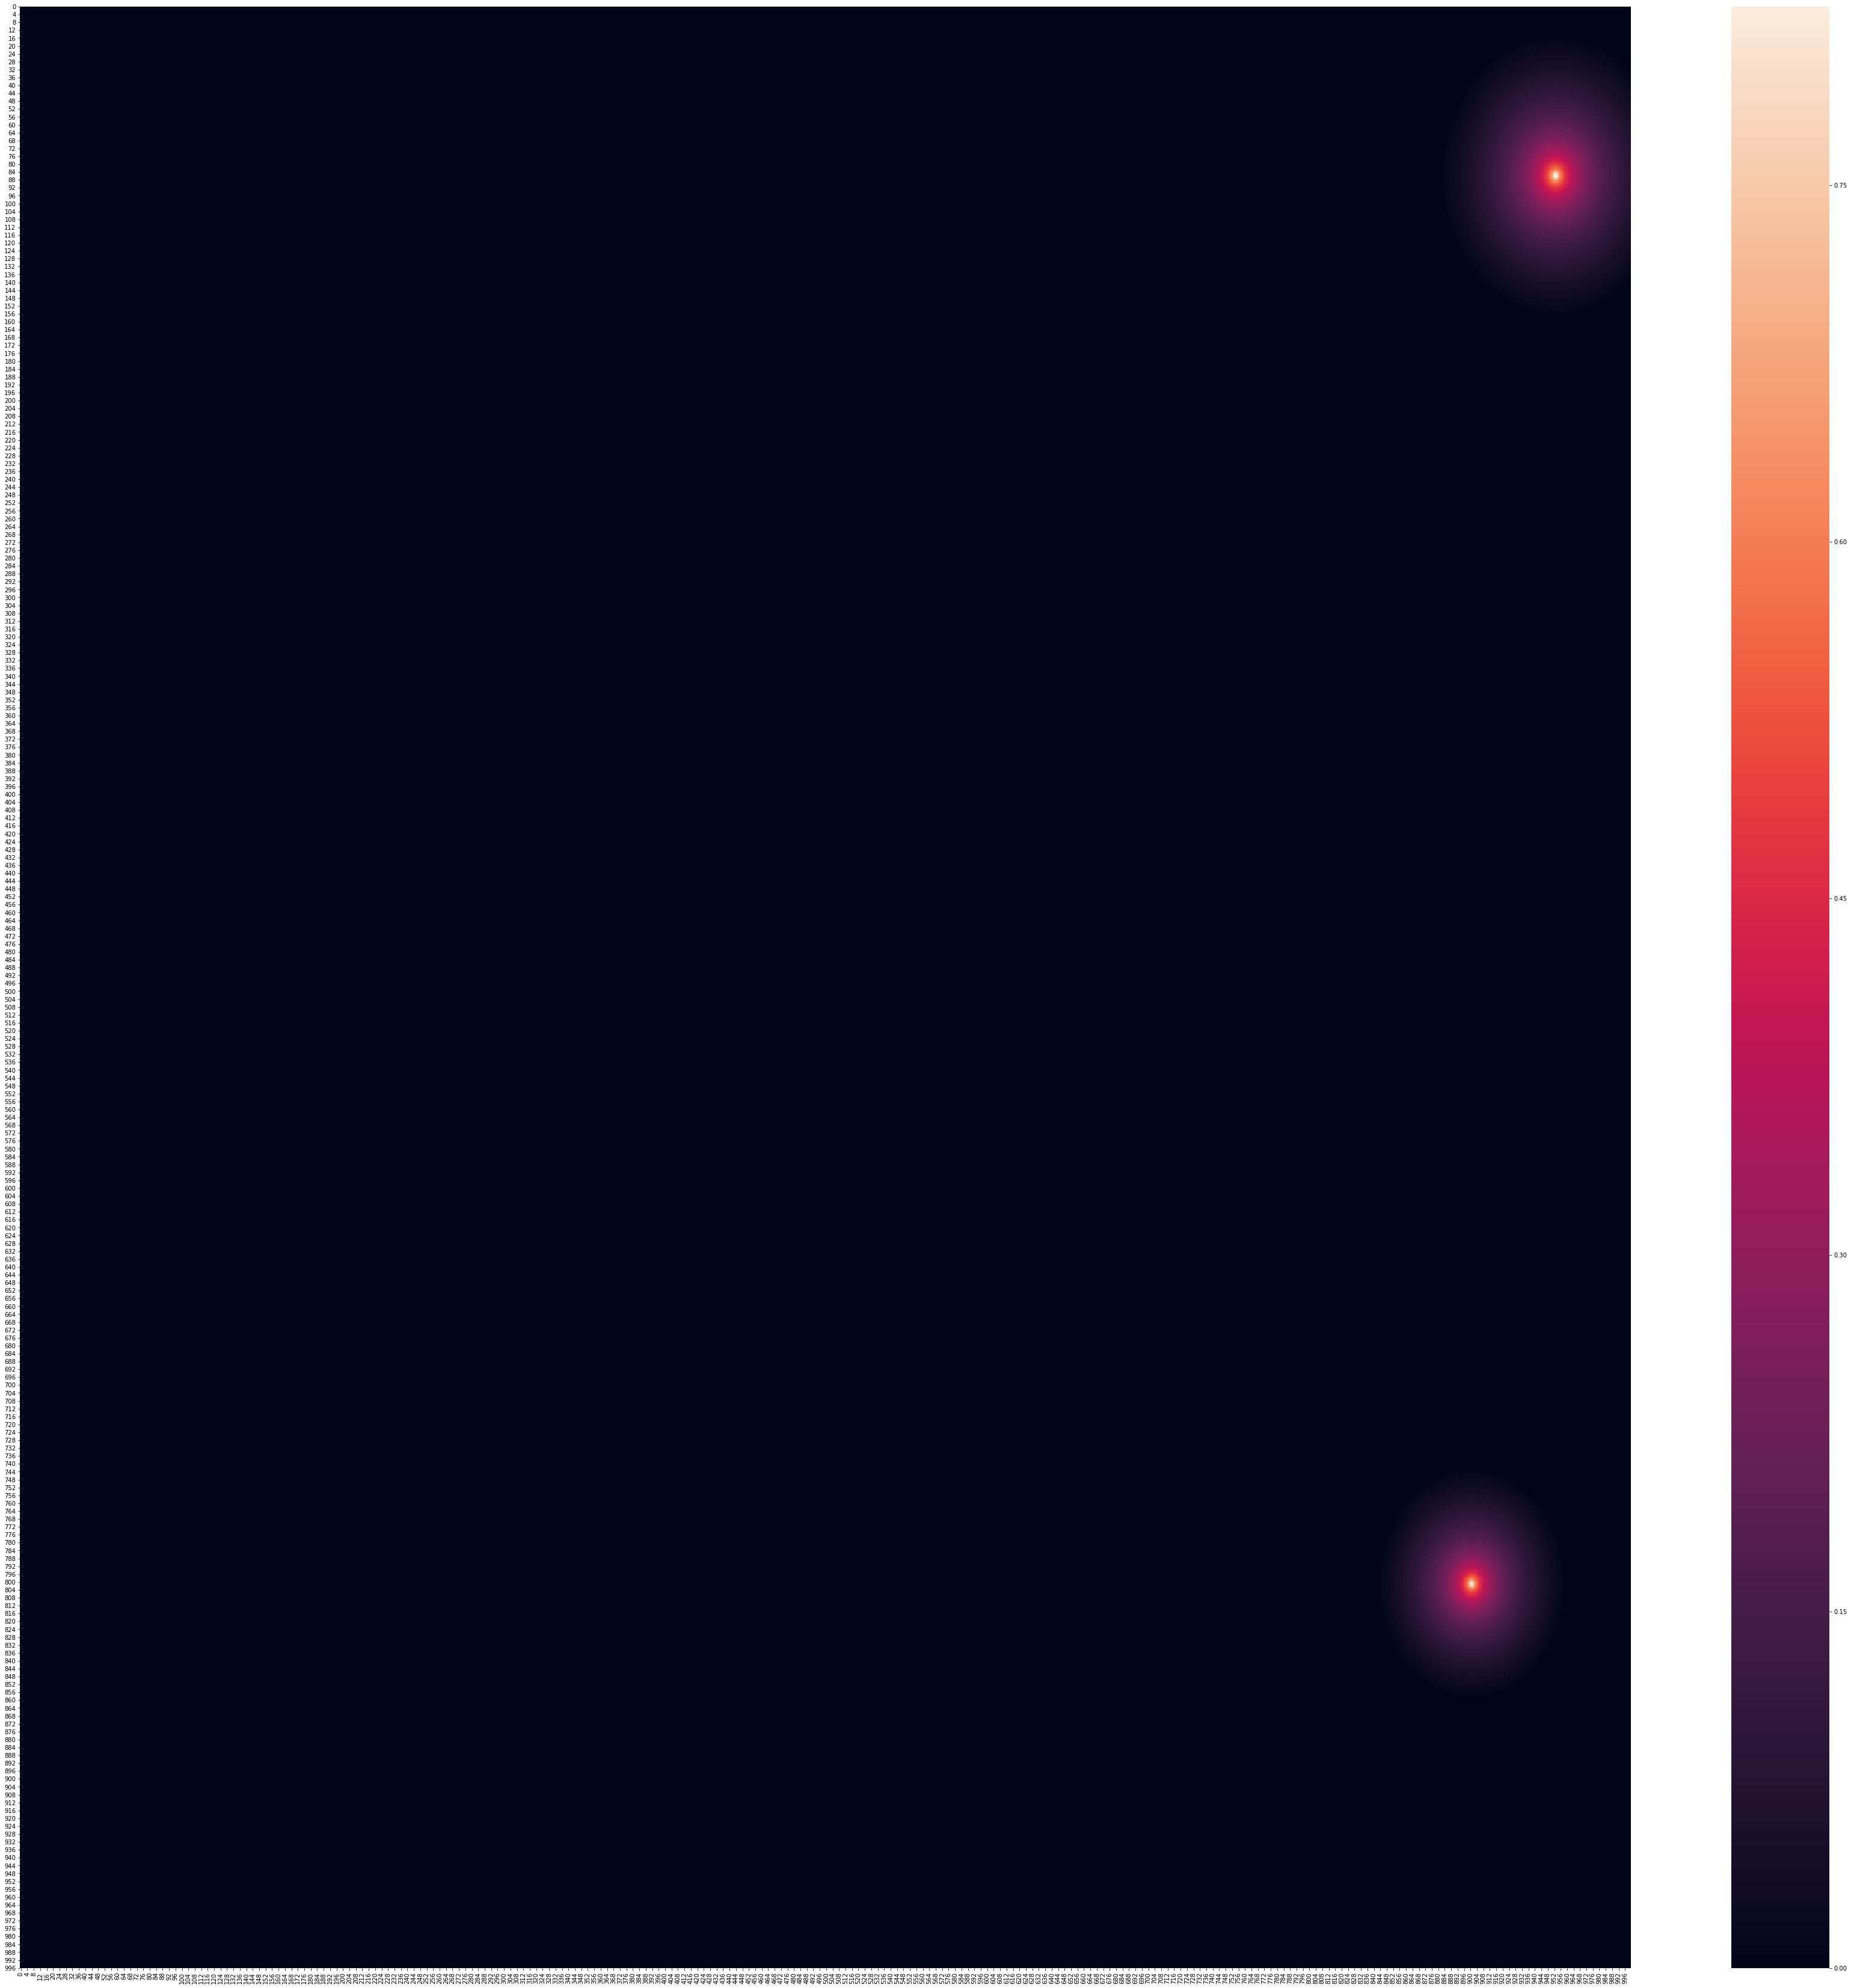

In [34]:
fig, ax = plt.subplots(figsize=(60,60))         # Sample figsize in inches
sns.heatmap(imm[0][3], ax=ax)

In [11]:
def cnn_model(num_filters, kernel_lam, bias_lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"
    convolution_filter, dense_filter = 'selu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (3, 3), (2,2)
    cnn = models.Sequential()
    cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(2*num_filters, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, 
#                           input_shape=(number_image_channels, max_x, max_y), data_format=data_format,
#                           kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                           kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(2*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Conv2D(4*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam), 
                         kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Conv2D(3*num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
#                          kernel_initializer='lecun_normal'))
    cnn.add(layers.MaxPooling2D(pool_size, data_format=data_format))
    cnn.add(BatchNormalization(axis=1))
#     cnn.add(layers.Dropout(0.25))
    
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
    cnn.add(BatchNormalization())
    cnn.add(layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init))
#     cnn.add(BatchNormalization())
    cnn.add(layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init))
    return cnn


class DataBatchGenerator(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int, number_image_channels:int,
                 max_x, max_y, float_memory_used, conserve=0):
#         print(dataset.shape[0])
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.conserve = conserve
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(np.int)
    
    def __getitem__(self, idx):
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.number_image_channels, self.max_x, self.max_y), dtype=self.float_memory_used)
        batch_y = np.empty((size), dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i)
            batch_y[i] = self.dataset[idx * self.batch_size + i][- 1 - self.conserve]
        return batch_x, batch_y
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)
         

In [12]:
cnn = cnn_model(10, 0, 0)

In [13]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 1000, 1000)    640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 500, 500)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 500, 500)      40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 500, 500)      1820      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 250, 250)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 250, 250)      80        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 250, 250)     

In [14]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [15]:
# CNN: support batching
TEST, CONSERVE = True, True
mini_batch, epochs = 16, 25
MAX_QUEUE_SIZE, WORKERS = 6, 1
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = 'val_mae', 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0, 0.001, 0.01, 0.1, 1]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3
# MODEL_PATH = 'models/'
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
# average_diff_power, fp_mean_power = [7.568, 7.916],[3.357, 2.705] 
# checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb_idx)+ '.h5',
#                                  verbose=1, save_best_only=True, monitor=hyper_metric, mode=mode, period=1)
#                  for lamb_idx in range(len(lambda_vec))]

for num_sample_idx, number_sample in enumerate(number_samples):
#     if num_sample_idx < 3:
#         continue
#     if num_sample_idx == 0:
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer='adam', 
                        metrics=['mse', 'mae', fp_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb_idx)+ '.h5',
                                         verbose=1, save_best_only=True, monitor=hyper_metric, mode=mode, period=1)
                         for lamb_idx in range(len(lambda_vec))]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb_idx) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb_idx in range(len(lambda_vec))]
    number_start = time.time()
    train_generator = DataBatchGenerator(dataset=data_reg[prev_sample:number_sample], batch_size=mini_batch,
                                         start_idx=prev_sample, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

    val_size = math.ceil(number_sample * validation_size)
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample, number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)

    for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=0, validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
#     if num_sample_idx == 3:    
#         models_min_mae = [8.27781, 8.23545, 8.20838, 7.74743]
#         models_min_mae += [min(cnns[lamb_idx].history.history[hyper_metric]) for lamb_idx in range(4,lamb_idx+1)]
#     else:
    models_min_mae = [min(cnns[lamb_idx].history.history[hyper_metric]) for lamb_idx in range(lamb_idx+1)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start)))
          ,", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    del cnns, train_generator, val_generator, checkpointers
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(best_lamb_idx) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae })
        test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        if CONSERVE:
            test_generator_conserve = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                                         batch_size=mini_batch,
                                                         start_idx=number_sample + val_size, 
                                                         number_image_channels=number_image_channels,
                                                         max_x=max_x, max_y=max_y, 
                                                         float_memory_used=float_memory_used, 
                                                         conserve=1)
            test_res_conserve = best_model.evaluate(test_generator_conserve, verbose=1, 
                                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                                                    use_multiprocessing=False)
            test_mae_cons, test_fp_mae_cons = test_res_conserve[test_mae_idx], test_res_conserve[test_fp_mae_idx]
            average_diff_power_conserve.append(round(test_mae_cons, 3))
            fp_mean_power_conserve.append(round(test_fp_mae_cons, 3))
            print('Conserve, average_error: ', average_diff_power_conserve[-1], ', fp_average_error: ',
                 fp_mean_power_conserve[-1])
        print("\n\n")

        
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
                     dataset_name, max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve],
                    file=var_f)
        var_f.close()
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 4096 , New samples: 4096
Validation size: 1352 , starts: 4096 , ends: 5447

Epoch 00001: val_mae improved from inf to 11.00961, saving model to ML/data/pictures_1000_1000/log/noisy_std_1/pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/models/4096/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 11.00961 to 8.26318, saving model to ML/data/pictures_1000_1000/log/noisy_std_1/pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/models/4096/best_model_lambda_0.h5

Epoch 00003: val_mae improved from 8.26318 to 7.41148, saving model to ML/data/pictures_1000_1000/log/noisy_std_1/pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/models/4096/best_model_lambda_0.h5

Epoch 00004: val_mae did not improve from 7.41148

Epoch 00005: val_mae did not improve from 7.41148

Epoch 00006: val_mae improved from 7.41148 to 7.33490, saving model to ML/data/pictures_1000_1000/log/noisy_std_1/pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/


Epoch 00009: val_mae improved from 6.30239 to 6.17239, saving model to ML/data/pictures_1000_1000/log/noisy_std_1/pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/models/4096/best_model_lambda_2.h5

Epoch 00010: val_mae improved from 6.17239 to 5.25635, saving model to ML/data/pictures_1000_1000/log/noisy_std_1/pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/models/4096/best_model_lambda_2.h5

Epoch 00011: val_mae did not improve from 5.25635

Epoch 00012: val_mae did not improve from 5.25635

Epoch 00013: val_mae improved from 5.25635 to 4.93893, saving model to ML/data/pictures_1000_1000/log/noisy_std_1/pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/models/4096/best_model_lambda_2.h5

Epoch 00014: val_mae did not improve from 4.93893

Epoch 00015: val_mae did not improve from 4.93893

Epoch 00016: val_mae did not improve from 4.93893

Epoch 00017: val_mae did not improve from 4.93893

Epoch 00018: val_mae did not improve from 4.93893

Epoch 

Test starts:  5448 , ends:  45983
2534/2534 [==============================] - 1839s 726ms/step
average_error:  4.64 , fp_average_error:  2.619
2534/2534 [==============================] - 1843s 727ms/step
Conserve, average_error:  4.657 , fp_average_error:  1.998



number_samples: 8192 , New samples: 8192
Validation size: 2704 , starts: 8192 , ends: 10895

Epoch 00001: val_mae improved from inf to 7.71762, saving model to ML/data/pictures_1000_1000/log/noisy_std_1/pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/models/8192/best_model_lambda_0.h5

Epoch 00002: val_mae improved from 7.71762 to 7.41464, saving model to ML/data/pictures_1000_1000/log/noisy_std_1/pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/models/8192/best_model_lambda_0.h5

Epoch 00003: val_mae did not improve from 7.41464

Epoch 00004: val_mae improved from 7.41464 to 6.81221, saving model to ML/data/pictures_1000_1000/log/noisy_std_1/pu_circle_su_circle_30/raw_power_min_max_norm/color/lo


Epoch 00014: val_mae did not improve from 4.09170

Epoch 00015: val_mae did not improve from 4.09170

Epoch 00016: val_mae did not improve from 4.09170

Epoch 00017: val_mae did not improve from 4.09170

Epoch 00018: val_mae did not improve from 4.09170

Epoch 00019: val_mae did not improve from 4.09170

Epoch 00020: val_mae did not improve from 4.09170

Epoch 00021: val_mae did not improve from 4.09170

Epoch 00022: val_mae did not improve from 4.09170

Epoch 00023: val_mae did not improve from 4.09170

Epoch 00024: val_mae did not improve from 4.09170

Epoch 00025: val_mae did not improve from 4.09170

Lambda: 0.01 , Time: 3:46:11
Train Error(all epochs): 2.4397619 
 [13.288, 7.341, 5.824, 4.828, 4.467, 4.28, 4.121, 3.95, 3.829, 3.748, 3.652, 3.502, 3.428, 3.33, 3.257, 3.167, 3.046, 3.018, 2.877, 2.79, 2.705, 2.641, 2.639, 2.527, 2.44]
Train FP Error(all epochs): 1.2084498 
 [1.854, 3.46, 2.831, 2.337, 2.228, 2.101, 2.032, 1.961, 1.897, 1.854, 1.819, 1.745, 1.708, 1.658, 1.626, 1.56

In [14]:
models_min_mae = [8.27781, 8.23545, 8.20838]

In [ ]:
average_diff_power = [8.166, 7.844, 7.592]
fp_mean_power = [4.56, 4.42, 4.37]

In [6]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
# print(best_lambda)
print(average_power_conserve)
print(fp_mean_power_conserve)
print(best_lambda)

[256, 512, 1024, 2048, 4096, 8192]
[7.376, 7.312, 7.505, 5.391]
[5.207, 4.595, 5.154, 2.383]
[7.237, 7.308, 7.389, 5.607]
[4.509, 3.964, 4.467, 1.862]
[1, 1, 0.1, 0.001]


In [15]:
# CNN: support batching
TEST = True
mini_batch, epochs = 16, 30
batch_size = (batch_size // mini_batch) * mini_batch
prev_sample = 0
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]  #, 0.3, 1, 3, 10
average_diff_power, fp_mean_power = [], []
cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
for cnn in cnns:
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
for number_sample in number_samples:
    number_start = time.time()
    current_sample = number_sample - prev_sample
    train_samples = [batch_size] * (current_sample//batch_size) + ([current_sample%batch_size] if 
                                                                    current_sample%batch_size else [])
    val_size = math.ceil(number_sample * validation_size)
#     val_samples = [batch_size] * (val_size//batch_size) + ([val_size%batch_size] if 
#                                                                val_size%batch_size else [])
    
    print('number_samples:', number_sample)
    print("Train batches:", train_samples)
    for i, train_sample in enumerate(train_samples):
        print("Train batch#:", i, ", batch size:", train_sample, ", starts:", prev_sample + i * batch_size,
                      ", ends:", prev_sample + i * batch_size + train_sample - 1)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
#     print("Validation Batches:", val_samples)
#     for i, val_sample in enumerate(val_samples):
#         print("Validation batch#:", i, ", batch size:", val_sample, ", starts:", number_sample + i * batch_size,
#                       ", ends:", number_sample + i * batch_size + val_sample - 1)
        
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb_idx, lamb in enumerate(lambda_vec):
        lambda_start = time.time()
        
#         cnn = cnn_model(10, lamb, 0)
#         cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
        # training on all batches
        for i, train_sample in enumerate(train_samples):
#             if lamb_idx == 0:
#                 print("Train batch#:", i, ", batch size:", train_sample, ", starts:", prev_sample + i * batch_size,
#                       ", ends:", prev_sample + i * batch_size + train_sample - 1)
            x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
            y_train = np.empty((train_sample), dtype=float_memory_used)
            for image_num in range(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample):
                x_train[(image_num - prev_sample) % batch_size] = read_image(image_num)
                y_train[(image_num - prev_sample) % batch_size] = np.asarray(data_reg[image_num][-1], 
                                                                             dtype=float_memory_used)
            cnns[lamb_idx].fit(x_train, y_train, epochs=epochs, verbose=2, batch_size=mini_batch,
                               validation_split=0.2, 
                               shuffle=True)
            del x_train, y_train
#         if lamb_idx == 0:
#             print("Validation size:", val_size, ", starts:", number_sample, ", ends:", 
#                   number_sample + val_size - 1)
        print("\nLambda:", lamb)
        print("Train Error(all epochs): ", cnns[lamb_idx].history.history['mae'])
        
        # validating
        val_mae, val_fp_mae = 0.0, 0.0
#         for i, val_sample in enumerate(val_samples):
#             x_val = np.empty((val_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
#             for image_num in range(val_sample):
#                 x_val[image_num] = read_image(image_num + number_sample + i * batch_size)
#             yp_val = cnns[lamb_idx].predict(x_val)
        for image_num in range(val_size):
            val_y = data_reg[image_num + number_sample][-1]
            image = read_image(image_num + number_sample)
            val_yp = cnns[lamb_idx].predict(image)[0][0]
#             for image_num in range(val_sample):
#                 val_yp = yp_val[image_num][0]
#                 val_y = data_reg[image_num + number_sample + i * batch_size][-1]
            val_mae += abs(val_y - val_yp)
            if val_yp > val_y:
                val_fp_mae += abs(val_yp - val_y)
        val_mae /= val_size
        val_fp_mae /= val_size
        print("Val Error:", round(val_mae, 3), ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        if val_mae < min_error:
            min_error = val_mae
            best_model = cnns[lamb_idx]
            best_lam = lamb
            best_lam_idx = lamb_idx
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - number_start)))
          ,", best_lambda:", best_lam, ", min_error:", round(min_error, 3))
    
    
    if TEST:
        # evaluating test images
        sum_mae, sum_fp_mae = 0, 0
        test_size = 0

        y_test_p = np.empty((data_reg.shape[0] - (number_sample + val_size)), dtype=float_memory_used)
    #     test_size = data_reg.shape[0] - (number_sample + val_size)
    #     test_samples = [batch_size] * (test_size//batch_size) + ([test_size%batch_size] if 
    #                                                              test_size%batch_size else [])
        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
    #     for i, test_sample in tqdm.tqdm(enumerate(test_samples)):
    #         x_test = np.empty((test_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
    #         for image_num in range(test_sample):
    #             x_test[image_num] = read_image(number_sample + val_size + i * batch_size)
    #         yp_test = cnns[best_lam_idx].predict(x_test)
    #         for image_num in range(test_sample):
    #             test_y = data_reg[number_sample + val_size + i * batch_size][-1]
    #             test_yp = yp_test[image_num][0]
    #             sum_mae += abs(test_yp - test_y)
    #             if test_yp > test_y:
    #                 sum_fp_mae += abs(test_yp - test_y)

        for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
            test_size += 1
            test_image = read_image(test_num)
            test_y = data_reg[test_num][-1]
            test_yp = best_model.predict(test_image)[0][0]
            y_test_p[test_num - (number_sample + val_size)] = test_yp
            sum_mae += abs(test_yp - test_y)
            if test_yp > test_y:
                sum_fp_mae += abs(test_yp - test_y)
        fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
        average_diff_power.append(round(sum_mae / test_size, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        print("\n\n")
        var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
        pickle.dump([average_diff_power, fp_mean_power, number_samples], file=var_f)
        var_f.close()
    prev_sample = number_sample

SystemError: <built-in function GetOperationInputs> returned a result with an error set

In [24]:
cnns[1].weights

[<tf.Variable 'conv2d_216_1/kernel:0' shape=(3, 3, 7, 10) dtype=float32, numpy=
 array([[[[ 0.13334414, -0.0261361 , -0.07441936,  0.16142276,
            0.10993325,  0.04581179,  0.24121895,  0.23147854,
            0.17021964, -0.0591266 ],
          [ 0.09241038,  0.10264444,  0.00484879, -0.02517582,
            0.06216534, -0.06764037,  0.02806018,  0.08384448,
            0.13874047,  0.15180951],
          [ 0.1893204 , -0.05741746,  0.00313846,  0.03854534,
           -0.20698836,  0.00660574, -0.1372445 , -0.11774021,
            0.10552079, -0.1360089 ],
          [-0.1331031 ,  0.02123114,  0.00091115, -0.03792882,
            0.22543769, -0.07044397, -0.09563252, -0.04734167,
           -0.09483308,  0.04207201],
          [ 0.06165536,  0.04747773,  0.00436929,  0.0485286 ,
           -0.16992377,  0.06714778,  0.20848735,  0.16978653,
           -0.07686065, -0.09264071],
          [ 0.08572359, -0.19217153, -0.08705788,  0.12219634,
           -0.27800012,  0.1237585 , 

In [15]:
# CNN: support batching
prev_sample = 0
# number_samples = [120, 200, 700]
lambda_vec = [0, 0.001]  #0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10
average_diff_power, fp_mean_power = [], []
cnns = [cnn_model(10, lamb, 0) for lamb in lambda_vec]
for cnn in cnns:
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
for number_sample in number_samples:
    current_sample = number_sample - prev_sample
    print("prev: ", prev_sample, ", now: ", number_sample, ", size", current_sample) 
    train_samples = [batch_size] * (current_sample//batch_size) + ([current_sample%batch_size] if 
                                                                    current_sample%batch_size else [])
    print(train_samples)
    
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb_idx, lamb in enumerate(lambda_vec):
        print("Lambda:", lamb)
#         cnn = cnn_model(10, lamb, 0)
#         cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
        # training on all batches
                                    
        for i, train_sample in enumerate(train_samples):
            for image_num in range(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample):
                print(prev_sample + i * batch_size, prev_sample + i * batch_size + train_sample)
                print((prev_sample + i * batch_size - prev_sample) % batch_size, 
                      (prev_sample + i * batch_size + train_sample - prev_sample)% batch_size)
                break

        
        # validating
        print("validating")
        val_size = math.ceil(number_sample * validation_size)
        for image_num in range(val_size):
            print(number_sample, val_size + number_sample)
            break
     
    print("Test") 
    
    # evaluating test images

    
    for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
        print(number_sample + val_size, data_reg.shape[0])
        break
    prev_sample = number_sample

  0%|          | 0/43033 [00:00<?, ?it/s]

prev:  0 , now:  2000 , size 2000
[383, 383, 383, 383, 383, 85]
Lambda: 0
0 383
0 0
383 766
0 0
766 1149
0 0
1149 1532
0 0
1532 1915
0 0
1915 2000
0 85
validating
2000 2660
Lambda: 0.001
0 383
0 0
383 766
0 0
766 1149
0 0
1149 1532
0 0
1532 1915
0 0
1915 2000
0 85
validating
2000 2660
Test
2660 48353
prev:  2000 , now:  4000 , size 2000
[383, 383, 383, 383, 383, 85]
Lambda: 0
2000 2383
0 0
2383 2766
0 0
2766 3149
0 0
3149 3532
0 0
3532 3915
0 0
3915 4000
0 85
validating
4000 5320
Lambda: 0.001
2000 2383
0 0
2383 2766
0 0
2766 3149
0 0
3149 3532
0 0
3532 3915
0 0
3915 4000
0 85
validating
4000 5320
Test
5320 48353


In [40]:
var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + 'best_cnn_4000samples' + intensity_degradation + '_' + str(slope) + '_' + 
                 dtime + ".dat", "wb") # file for saving results
pickle.dump(best_model, file=var_f)
var_f.close()

In [21]:
## use self-training
unlabeled_train_samples = [batch_size] * (len(y_test_p)//batch_size) + ([len(y_test_p)%batch_size] if len(y_test_p)%batch_size else [])
labeled_train_samples = [batch_size] * (number_sample//batch_size) + ([number_sample%batch_size] if number_sample%batch_size else [])   
min_min_error = float('inf')
best_best_model, best_best_lam = None, None
for lamb in tqdm.tqdm(lambda_vec):
    print("Lambda:", lamb)
    cnn = cnn_model(10, lamb, 0)
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#     cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
        
    # training on all batches
    # training on all batches
    for i, train_sample in tqdm.tqdm(enumerate(labeled_train_samples)):
        x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
        y_train = np.empty((train_sample), dtype=float_memory_used)
        for image_num in range(i * batch_size, i * batch_size + train_sample):
            x_train[image_num % batch_size] = read_image(image_num)
            y_train[image_num % batch_size] = np.asarray(data_reg[image_num][-1], dtype=float_memory_used)
        cnn.fit(x_train, y_train, epochs=6, verbose=0, batch_size=1, validation_split=0.0)
        del x_train, y_train
            
    for i, train_sample in tqdm.tqdm(enumerate(unlabeled_train_samples)):
        x_train = np.empty((train_sample, number_image_channels, max_x, max_y), dtype=float_memory_used)
        y_train = np.empty((train_sample), dtype=float_memory_used)
        for image_num in range(i * batch_size + number_sample + val_size, i * batch_size + number_sample + val_size + train_sample):
            x_train[(image_num-number_sample - val_size) % batch_size] = read_image(image_num)
            y_train[(image_num-number_sample - val_size) % batch_size] = np.asarray(y_test_p[image_num-(number_sample + val_size)], dtype=float_memory_used)
        cnn.fit(x_train, y_train, epochs=3, verbose=0, batch_size=1, validation_split=0.0)
        del x_train, y_train
        
    # validating
    val_size = math.ceil(number_sample * validation_size)
    val_mae, val_fp_mae = 0.0, 0.0
    for image_num in range(val_size):
        val_y = data_reg[image_num + number_sample][-1]
        image = read_image(image_num + number_sample)
        val_yp = cnn.predict(image)[0][0]
        val_mae += abs(val_y - val_yp)
        if val_yp > val_y:
            val_fp_mae += abs(val_yp - val_y)
    val_mae /= val_size
    val_fp_mae /= val_size
    print(val_mae)
    if val_mae < min_min_error:
        min_min_error = val_mae
        best_best_model = cnn
        best_best_lam = lamb
    sum_mae, sum_fp_mae = 0, 0
    test_size = 0
    
for test_num in tqdm.tqdm(range(number_sample + val_size, data_reg.shape[0])):
    test_size += 1
    test_image = read_image(test_num)
    test_y = data_reg[test_num][-1]
    test_yp = best_best_model.predict(test_image)[0][0]
#     y_test_p[test_num - (number_sample + val_size)] = test_yp
    sum_mae += abs(test_yp - test_y)
    if test_yp > test_y:
        sum_fp_mae += abs(test_yp - test_y)
fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
average_diff_power.append(round(sum_mae / test_size, 3))
print('number_samples: ', number_sample, ', average_error: ', average_diff_power[-1], ' fp_average_error: ', 
      fp_mean_power[-1])
print("\n")

  0%|          | 0/6 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Lambda: 0



1it [00:57, 57.66s/it]

0it [00:00, ?it/s]
1it [02:23, 143.92s/it]
2it [04:46, 143.57s/it]
3it [07:09, 143.27s/it]
4it [09:32, 143.17s/it]
5it [10:23, 124.68s/it]
 17%|█▋        | 1/6 [11:23<56:58, 683.79s/it]
0it [00:00, ?it/s]

7.211368327594533
Lambda: 0.001



1it [00:56, 56.09s/it]

0it [00:00, ?it/s]
1it [02:19, 139.20s/it]
2it [04:38, 139.22s/it]
3it [06:57, 139.21s/it]
4it [09:18, 139.72s/it]
5it [10:08, 121.72s/it]
 33%|███▎      | 2/6 [22:31<45:15, 678.85s/it]
0it [00:00, ?it/s]

7.379879925942782
Lambda: 0.003



1it [00:58, 58.13s/it]

0it [00:00, ?it/s]
1it [02:24, 144.03s/it]
2it [04:48, 144.30s/it]
3it [07:14, 144.74s/it]
4it [09:39, 144.71s/it]
5it [10:31, 126.24s/it]
 50%|█████     | 3/6 [34:03<34:08, 682.78s/it]
0it [00:00, ?it/s]

6.986079897483191
Lambda: 0.01



1it [00:56, 56.09s/it]

0it [00:00, ?it/s]
1it [02:18, 138.72s/it]
2it [04:37, 138.66s/it]
3it [06:56, 138.75s/it]
4it [09:14, 138.70s/it]
5it [10:04, 120.90s/it]
 67%|██████▋   | 4/6 [45:06<22:33, 676.92s/it]
0it [00:00, ?it/s]

7.314812567979636
Lambda: 0.03



1it [00:55, 55.93s/it]

0it [00:00, ?it/s]
1it [02:18, 138.30s/it]
2it [04:36, 138.31s/it]
3it [06:54, 138.26s/it]
4it [09:12, 138.16s/it]
5it [10:02, 120.43s/it]
 83%|████████▎ | 5/6 [56:06<11:12, 672.05s/it]
0it [00:00, ?it/s]

7.257873288155691
Lambda: 0.1



1it [00:56, 56.58s/it]

0it [00:00, ?it/s]
1it [02:20, 140.02s/it]
2it [04:40, 140.21s/it]
3it [07:00, 140.04s/it]
4it [09:20, 139.96s/it]
5it [10:10, 122.09s/it]
  0%|          | 27/41779 [00:00<02:35, 269.14it/s]

8.043452635827206


100%|██████████| 41779/41779 [02:38<00:00, 263.33it/s]

number_samples:  2000 , average_error:  6.545  fp_average_error:  3.067




In [ ]:
6.285, 6.366, 6.45, 6.454, 6.382, 6.26, 6.49, 6.224, 6.052, 5.87, 4.915, 4.836

In [ ]:
# CNN
prev_sample = 0
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1]
max_train_samples = math.ceil(number_samples[-1] * (1 + validation_size))
x_train = np.empty((max_train_samples, number_image_channels, max_x, max_y), dtype=float_memory_used)
# x_train1 = np.empty((max_train_samples, 1, max_x, max_y), dtype=float_memory_used)
# x_train2 = np.empty((max_train_samples, 1, max_x, max_y), dtype=float_memory_used)
y_train = np.empty((max_train_samples), dtype=float_memory_used)
average_diff_power, fp_mean_power = [], []
for number_sample in number_samples:
    sample = math.ceil(number_sample * (1 + validation_size))
    for image_num in range(prev_sample, sample):
        prev_sample = sample
        if style == "image_intensity":
            image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
            image = np.swapaxes(image, 0, 2)
            x_train[image_num] = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
            del image
        elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
            x_train[image_num] = np.load(image_dir + '/image' + str(image_num)+'.npy')
#             image = np.load(image_dir + '/image' + str(image_num)+'.npy')
#             x_train1[image_num][0] = image[0][0]
#             x_train2[image_num][0] = image[0][1]
        y_train[image_num] = np.asarray(data_reg[image_num][-1], dtype=float_memory_used)
        if image_num + 1 % 100 == 0:
            print(image_num)
#     cnn = cnn_model(7, 0, 0)
#     cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#     cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
#             (validation_size + 1))
    
    min_error = float('inf')
    best_model, best_lam = None, None
    for lamb in lambda_vec:
        print("Lambda:", lamb)
        cnn = cnn_model(10, lamb, 0)
        cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
#         cnn.fit([x_train1[:sample], x_train2[:sample]], y_train[:sample], epochs=6, verbose=1, batch_size=1, validation_split=validation_size/
#                 (validation_size + 1))
        cnn.fit(x_train[:sample], y_train[:sample], epochs=6, verbose=0, batch_size=1, validation_split=validation_size/
                (validation_size + 1))
        if cnn.history.history['val_mean_absolute_error'][-1] < min_error:
            min_error = cnn.history.history['val_mean_absolute_error'][-1]
            best_model = cnn
            best_lam = lamb
    print("best_lambda, ", best_lam, "min_error", min_error)    
    # evaluating test images
    sum_mae, sum_fp_mae = 0, 0
    test_size = 0
#     for test_num in range(max_train_samples, data_reg.shape[0]):
    for test_num in range(sample, data_reg.shape[0]):
        test_size += 1
        if style == "image_intensity":
            test_image = plt.imread(image_dir + '/image' + str(test_num) + '.png')
            test_image = np.swapaxes(test_image, 0, 2)
            test_image = np.array(test_image[:number_image_channels]).reshape(1, number_image_channels, max_x, max_y)
        elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm":
            test_image = np.load(image_dir + '/image' + str(test_num)+'.npy')
        test_y = data_reg[test_num][-1]
        test_yp = best_model.predict(test_image)[0][0]
        sum_mae += abs(test_yp - test_y)
        if test_yp > test_y:
            sum_fp_mae += abs(test_yp - test_y)
        if test_num % 500 == 0:
            print('test: ', test_num)
    fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
    average_diff_power.append(round(sum_mae / test_size, 3))
    print('number_samples: ', number_sample, ', average_error: ', average_diff_power[-1], ' fp_average_error: ', fp_mean_power[-1])
    print("\n")
    var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + dtime + ".dat", "wb") # file for saving results
    pickle.dump([average_diff_power, fp_mean_power, number_samples], file=var_f)
    var_f.close()       

In [ ]:
average_diff_power[8], average_diff_power[9] = average_diff_power[9], average_diff_power[8]
# fp_mean_power = fp_mean_power[::-1]

In [ ]:
input_shapee = Input(shape=(number_image_channels, max_x, max_y))

In [ ]:
input_shapee[3]

In [ ]:
cnn = cnn_model(1, 0)
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [ ]:
print(cnn.history.history['val_mean_absolute_error'][-1])

In [ ]:
cnn = cnn_model(10, 0, 0)
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [ ]:
cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
            (validation_size + 1))

In [ ]:
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
min_error = float('inf')
best_model, best_lam = None, None
for lamb in lambda_vec:
    print("Lambda:", lamb)
    cnn = cnn_model(15, lamb, 0)
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
    cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size/
            (validation_size + 1))
    if cnn.history.history['val_mean_absolute_error'][-1] < min_error:
        min_error = cnn.history.history['val_mean_absolute_error'][-1]
        best_model = cnn
        best_lam = lamb
    print("\n")
    

In [ ]:
print(best_lam)
print(best_model.history.history)

In [ ]:
# just run to dispaly the image. First change return line from create_image
aa = np.swapaxes(np.append(np.array(x_train[50]), np.zeros((2,max_x, max_y), dtype=float_memory_used), axis=0), 0, 2)
plt.imshow(aa)
# plt.imsave('image.png', aa)

In [ ]:
average_diff_power

In [ ]:
cnn.summary()

In [ ]:
# use this cell to read saved variables
var_ff = open('ML/data/pictures_1000_1000/log_201912_0705_37.txt', 'rb')
[average_diff_power_1, fp_mean_power_1, number_samples_1] = pickle.load(var_ff)

In [ ]:
fp_mean_power

In [ ]:
average_diff_power[-1]*(data_reg.shape[0] - max_train_samples)/(300-sample)

In [ ]:
sum_fp_mae/200

In [ ]:
fp_mean_power

In [ ]:
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

In [ ]:
# PARALLEL CNN
def cnn_model(num_filters, kernel_lam, bias_lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_filter, dense_filter = 'selu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (3, 3), (2,2)
    # CNN for PU image
    input1  = layers.Input(shape=(number_image_channels - 1, max_x, max_y), name='pus_input')
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(input1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    x1 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels - 1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x1)
    x1 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x1)
    
    
    # CNN for SU
    input2  = layers.Input(shape=(1, max_x, max_y), name='su_input')
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(input2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    x2 = layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(1, max_x, max_y), data_format=data_format,
                          kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                          kernel_initializer='lecun_normal')(x2)
    x2 = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(x2)
    
    
    # concatanate two CNN outputs
    x = layers.concatenate([x1, x2])
    x = layers.Flatten()(x)
    
    x = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    x = layers.Dense(20, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    out = layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                         bias_regularizer=regularizers.l2(bias_lam), kernel_initializer='lecun_normal')(x)
    
    model = models.Model(inputs=[input1, input2], outputs=out)
#     plot_model(model, to_file='model.png')
    return model

In [ ]:
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))

# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 1000, 1000, 2, 10
# pu_shape, su_shape = 'circle', 'square'
# style = "image_intensity"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 4
# average_diff_power = [9.110476626067186, 21.070721128267266, 9.389938883165568, 10.886098907990405,
#                                        7.697396928362106, 7.522477509027216, 9.493729427772132, 8.198866980620753,
#                                        7.781910785203122, 9.41743984825801, 8.499455442627129, 9.86776958065812,
#                                        9.033719411254367, 8.150143941293027, 8.963829050517273, 8.708150642874065,
#                                        7.468060397898071, 8.233182799553932,8.206, 7.768]
# fp_mean_power =  [8.174990557021465, 0.18043087058937837, 1.5141939559853392, 10.273307557711494,
#                                    3.2306742061521443, 4.423113329284006, 8.674172526579392, 2.38235061342411,
#                                    5.014172646429496, 6.884079514994618, 3.4544130456368367, 7.81721202679044,
#                                    6.438635364829745, 4.069245107144559, 5.202978504937615, 3.405858414831347,
#                                    4.117573271657338, 2.8100743146184377, 3.951, 3.502]

In [ ]:
### MAX_POWER ANAlysis
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))

# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 1000, 1000, 2, 10
# pus_num, intensity_degradation, slope = 15, 'log', 4
# pu_shape, su_shape = 'circle', 'circle'
# style = "image_intensity"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# test_size = 3670
# average_diff_power = [7.811849328268183, 9.178415418536536, 8.11891504382307, 7.881934146750136, 7.918868224324312,
#                       7.709452054502398, 7.471729821563216, 8.63783455122861, 7.7635068514166345, 8.557134470036884,
#                       8.103793715416188, 9.189284948409279, 11.977416480154307, 8.291134394492891, 8.960065032512803,
#                       9.992745143323642, 8.475335283779392, 8.051642160173987, 7.322538645284376, 7.768582958795206]
# fp_mean_power = [6.1844398077234635, 1.6157812496465958, 6.5620574110067595, 2.898169187355567, 6.262096880097353,
#                  2.5478307871639267, 3.5784209073932067, 7.416731632966506, 5.5822838290638135, 5.800529848947965,
#                  4.6984887763519785, 2.337296353076653, 9.85739104089764, 3.710259461284922, 5.323224159423669, 
#                  6.198328912769283, 2.302462751745074, 4.023802978234984, 3.781413967880959, 3.2793608103510508]



In [ ]:
# INIT
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))

# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 1000, 1000, 2, 10
# pu_shape, su_shape = 'circle', 'circle'
# style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 4
# if su_shape == 'circle':
#     su_param = Circle(su_szie)
# elif su_shape == 'square':
#     su_param = Square(su_szie)
# num_pus = 15
average_diff_power = [9.711, 7.867, 8.958, 7.571, 7.509, 7.891, 8.272, 7.118, 7.696, 7.689, 8.026, 9.674, 7.51, 7.771, 8.17,
                      7.938, 7.869, 7.833, 9.434, 8.501]
fp_mean_power = [9.229, 5.101, 8.037, 3.993, 5.095, 2.491, 2.298, 4.654, 3.787, 2.685, 5.676, 8.033, 3.911, 4.235, 3.278,
                 5.809, 3.586, 4.257, 4.377, 5.015]

In [ ]:
# INIT

# number_samples = [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 8001, 1000))


# cnn_type = "classification"  # {"classification", "regression"}
# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 200, 200, 2, 10
# pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
# style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 4
# if su_shape == 'circle':
#     su_param = Circle(su_szie)
# elif su_shape == 'square':
#     su_param = Square(su_szie)
# else:
#     su_param = None
# sensors = False
# if sensors:
#     sensors_num = 50
#     sensors_file_path = "rsc/" + str(sensors_num) + "/sensors"
    
average_diff_power = [6.779, 5.645, 5.473, 4.982, 4.481, 4.071, 4.05, 3.639, 2.813, 2.343, 2.21, 2.372, 2.005, 1.997,
                      1.937, 1.901]

fp_mean_power = [4.073, 2.409, 3.424, 3.163, 2.833, 2.663, 2.857, 2.744, 1.744, 1.33, 1.184, 1.55, 0.579, 1.216, 1.492, 1.266]


In [ ]:
# INIT

number_samples = [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 6001, 1000)) + [8000]
# dataframe = pd.read_csv('ML/data/dynamic_pus_using_pus50000_15PUs_201912_3000_40_200.txt', delimiter=',', header=None)
# dataframe_max = pd.read_csv('ML/data/dynamic_pus_max_power50000_15PUs_201912_3000_40_200.txt', delimiter=',', header=None)


# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 200, 200, 4, 10
# pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
# style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
# pus_num, intensity_degradation, slope = 15, 'log', 5
# if su_shape == 'circle':
#     su_param = Circle(su_szie)
# elif su_shape == 'square':
#     su_param = Square(su_szie)
# else:
#     su_param = None
# sensors = False
    
average_diff_power = [12.742, 12.906, 12.731, 12.595, 12.859, 13.272, 12.632, 12.647, 11.309, 7.455, 7.131, 5.677,
                      5.645, 5.292, 4.445]

fp_mean_power = [5.963, 5.861, 8.957, 8.821, 8.215, 9.518, 8.633, 6.644, 6.605, 3.919, 2.539, 3.866, 1.96, 2.717, 1.671]


In [ ]:
print(average_diff_power)

In [ ]:
line_width = 5
marker_size = 12
reg_style = 'solid'
class_reg = 'dashed'
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, average_diff_power, color='r', linewidth=line_width, markersize=marker_size, linestyle=class_reg)
plt.plot(number_samples, fp_mean_power, color='midnightblue', linewidth=line_width, markersize=marker_size, linestyle=class_reg)
plt.xlabel('# of Training Samples', fontsize=47)
plt.ylabel('Avg. Diff. wrt Opt. (dB)', fontsize=45)
plt.title('Dynamic PUs(200m*200m)')
plt.grid(True)

ax.set_yticks(np.arange(0,14, 2))
# ax.set_xticks(np.arange(100,7000, 1500))
plt.rcParams.update({'font.size': 42})
ax.tick_params(axis='x', labelsize=46)
ax.tick_params(axis='y', labelsize=45)

# matplotlib.rcParams.update({'font.size': 22})

ax.set_ylim([0, 14])
ax.set_xlim([0, 8000])
plt.legend(['Total', 'False-Positive'], ncol=2, loc='best', handletextpad=0.1,borderpad=0, columnspacing=0.2, borderaxespad=0.2)
# plt.legend(handletextpad=0.1)
plt.savefig('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + dtime + ".png", 
            bbox_inches = 'tight', pad_inches = 0)

In [ ]:
test_size

In [ ]:
a = np.load(image_dir + '/image10.npy')

In [ ]:
file.close()

In [ ]:
file = open('/'.join(image_dir.split('/')[:-1]) + '/log_5__202001_1519_01.dat', 'rb')

In [3]:
file = open('/home/shahrokh/projects/research/MLSpectrumAllocation/ML/data/pictures_1000_1000/log/noisy_std_1/' +
            'pu_circle_su_circle_30/raw_power_min_max_norm/color/log_4/pus/log_4__202005_0512_10.dat', 'rb')

In [4]:
[average_diff_power, fp_mean_power, number_samples, best_lambda, 
 dataset_name, max_dataset_name, average_power_conserve, fp_mean_power_conserve] = pickle.load(file)

In [5]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)
print(average_power_conserve)
print(fp_mean_power_conserve)

[256, 512, 1024, 2048, 4096, 8192]
[7.376, 7.312, 7.505, 5.391]
[5.207, 4.595, 5.154, 2.383]
[1, 1, 0.1, 0.001]
[7.237, 7.308, 7.389, 5.607]
[4.509, 3.964, 4.467, 1.862]


In [ ]:
print(fp1, fp2, fp3)

In [ ]:
print(samples1, samples2, samples3)

In [ ]:
len(samples3)